In [1]:
GOODFIRE_API_KEY = "sk-goodfire-dmKRWrIVThY26TCbxycGJjAO3q2gvxL2S3LBXuQk7ROn_qiJsk2CNA"

In [2]:
import goodfire

client = goodfire.Client(api_key=GOODFIRE_API_KEY)

In [ ]:
import pandas as pd

df = pd.read_csv("./data.csv", sep="|")

df["headline"] = df["headline"].fillna("")
df["text"] = df["ticker"] + ": " + df["headline"]


def classify_event_ret(event_ret):
    if pd.isna(event_ret):
        return "neutral"
    if event_ret > 0.01:
        return "positive"
    elif event_ret < -0.01:
        return "negative"
    else:
        return "neutral"


df["answer"] = df["eventRet"].apply(classify_event_ret)
df["answer"] = df["answer"].astype("category")

In [8]:
df

,ticker,headline,date,eventRet,Close,text,answer
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19,AMZN: Whole Foods (WFMI) -5.2% following a dow...,positive
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88,NFLX: Netflix (NFLX +1.1%) shares post early g...,negative
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63,MSFT: The likely winners in Microsoft's (MSFT ...,negative
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63,MSFT: Microsoft (MSFT -1.2%) and Skype signed ...,negative
4,MSFT,,2011-05-10,-0.019823,20.63,MSFT:,negative
...,...,...,...,...,...,...,...
2763,TSLA,"Responding to a comment on Twitter, Elon Musk ...",2018-12-24,0.041608,295.39,"TSLA: Responding to a comment on Twitter, Elon...",positive
2764,AMZN,Amazon (NASDAQ:AMZN) is among the companies th...,2018-12-24,0.013062,1343.96,AMZN: Amazon (NASDAQ:AMZN) is among the compan...,positive
2765,AAPL,Chinese companies urge employees to boycott (N...,2018-12-24,0.005634,143.92,AAPL: Chinese companies urge employees to boyc...,neutral
2766,TSLA,Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...,2018-12-26,-0.002856,326.09,TSLA: Elon Musk tweets that Tesla's (NASDAQ:TS...,neutral


In [10]:
df["answer"].value_counts()

answer
positive    1211
negative    1074
neutral      483
Name: count, dtype: int64

In [11]:
# Instantiate a Goodfire variant model
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

shuffled_df = df.sample(frac=1, random_state=42)
positive_examples = shuffled_df[shuffled_df["answer"] == "positive"]
negative_examples = shuffled_df[shuffled_df["answer"] == "negative"]
neutral_examples = shuffled_df[shuffled_df["answer"] == "neutral"]

FEATURE_COMPUTE_SIZE = 60
CLASSIFIER_FULL_SET_SIZE = 150  # Adjust as needed, but keep enough for each class

In [ ]:
# --- Contrastive Feature Extraction ---
prompt_template = "Is the following good or bad news for investors? {text}"

positive_news_features, negative_news_features = client.features.contrast(
    dataset_1=[
        [
            {
                "role": "user",
                "content": prompt_template.format(text=text),
            },
            {"role": "assistant", "content": "good"},
        ]
        for text in positive_examples[0:FEATURE_COMPUTE_SIZE]["text"].tolist()
    ],
    dataset_2=[
        [
            {
                "role": "user",
                "content": prompt_template.format(text=text),
            },
            {"role": "assistant", "content": "bad"},
        ]
        for text in negative_examples[0:FEATURE_COMPUTE_SIZE]["text"].tolist()
    ],
    model=variant,
    top_k=100,
)

In [17]:
# Rerank the contrastive features
positive_news_features = client.features.rerank(
    features=positive_news_features,
    query="price increase",
    model=variant,
    top_k=50,
)
negative_news_features = client.features.rerank(
    features=negative_news_features,
    query="price decrease",
    model=variant,
    top_k=50,
)
features_to_look_at = positive_news_features | negative_news_features
features_to_look_at

FeatureGroup([
   0: "Numerical or statistical change indicators in formal business contexts",
   1: "Dollar sign symbol in financial calculations and pricing",
   2: "Year-over-year growth percentages in financial reports",
   3: "Numerical comparisons in financial and statistical reporting",
   4: "Stock prices and current market values in financial contexts",
   5: "Reuters financial news wire reporting style and terminology",
   6: "Phrases describing numerical growth rates and percentages in business contexts",
   7: "Stock analyst recommendations and ratings",
   8: "Business and market growth potential in investment contexts",
   ...
   99: "Google products and services mentioned in lists of alternatives"
])

In [ ]:
from itertools import combinations


class FeatureSearch:
    def __init__(self, feature_group):
        self.feature_group = feature_group

    def grid(self, k_features_per_combo: int = 2):
        return list(combinations(self.feature_group, k_features_per_combo))

In [18]:
# --- Feature Activation Retrieval ---
async_client = goodfire.AsyncClient(api_key=GOODFIRE_API_KEY)

MIN_SAMPLES_PER_CLASS = min(
    len(negative_examples),
    len(positive_examples),
    len(neutral_examples),
    CLASSIFIER_FULL_SET_SIZE,
)
MIN_SAMPLES_PER_CLASS

150

In [14]:
from tqdm.asyncio import tqdm_asyncio


async def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=100,
    batch_size=10,
):
    if k < len(features_to_use_for_classification):
        raise ValueError(
            "k must be greater than the number of features to use for classification"
        )

    samples = []
    all_samples = sample_class[0:MIN_SAMPLES_PER_CLASS]

    for i in range(0, len(all_samples), batch_size):
        batch = all_samples[i : i + batch_size]
        tasks = []

        for idx, row in batch.iterrows():
            text = row["text"]
            tasks.append(
                async_client.features.inspect(
                    [
                        {
                            "role": "user",
                            "content": prompt_template.format(text=text),
                        }
                    ],
                    model=variant,
                    features=features_to_use_for_classification,
                )
            )

        batch_results = await tqdm_asyncio.gather(*tasks)
        for context in batch_results:
            features = context.top(k=k)
            samples.append(features)

    return samples


async def process_all_classes():
    print("Computing positive news features...")
    positive_class_features = await _get_feature_acts_for_sample_class(
        positive_examples, features_to_look_at, k=100
    )

    print("Computing negative news features...")
    negative_class_features = await _get_feature_acts_for_sample_class(
        negative_examples, features_to_look_at, k=100
    )

    print("Computing neutral news features...")  # Keep neutral separate!
    neutral_class_features = await _get_feature_acts_for_sample_class(
        neutral_examples, features_to_look_at, k=100
    )

    return positive_class_features, negative_class_features, neutral_class_features


positive_class_features, negative_class_features, neutral_class_features = (
    await process_all_classes()
)

Computing positive news features...


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Computing negative news features...


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Computing neutral news features...


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


In [19]:
# --- Decision Tree Training ---

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tqdm


def train_tree(x, y, depth):
    train_x, test_x, train_y, test_y = train_test_split(
        x, y, train_size=0.5, random_state=42
    )

    model = tree.DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=len(train_x) // 10,
        random_state=42,
        class_weight="balanced",
    )

    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    score = f1_score(test_y, pred, average="weighted")  # Use weighted F1
    return model, pred, score


def find_best_combo(features, k_features_per_combo=2):
    combos = FeatureSearch(features).grid(k_features_per_combo=k_features_per_combo)
    best_combo = None
    best_model = None
    best_score = 0

    for combo in tqdm.tqdm(combos):

        def _select_feature_acts(combo, row):
            output = []
            for index, feature in enumerate(combo):
                for feature_act in row:
                    if feature_act.feature.uuid == feature.uuid:
                        output.append(feature_act.activation)
                        break
            return output

        x_negative = [
            _select_feature_acts(combo, row) for row in negative_class_features
        ]
        x_neutral = [_select_feature_acts(combo, row) for row in neutral_class_features]
        x_positive = [
            _select_feature_acts(combo, row) for row in positive_class_features
        ]

        y_negative = [-1] * len(x_negative)
        y_neutral = [0] * len(x_neutral)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_neutral + x_positive
        y = y_negative + y_neutral + y_positive

        model, pred, score = train_tree(x, y, depth=len(combo))

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    return best_combo, best_score, best_model


best_combo_at_k = {}
for i in range(3):
    best_combo, best_score, best_model = find_best_combo(
        features_to_look_at, k_features_per_combo=i + 1
    )
    print(i + 1, best_combo, best_score, best_model)
    best_combo_at_k[i + 1] = (best_combo, best_score, best_model)

100%|██████████| 100/100 [00:01<00:00, 86.96it/s]


1 (Feature("The assistant is providing a detailed explanation or definition"),) 0.3802126871202016 DecisionTreeClassifier(class_weight='balanced', max_depth=1,
                       min_samples_leaf=22, random_state=42)


100%|██████████| 4950/4950 [01:09<00:00, 71.40it/s]


2 (Feature("Discussion of price movements and volatility in financial contexts"), Feature("The assistant is providing a detailed explanation or definition")) 0.49304556131671223 DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                       min_samples_leaf=22, random_state=42)


100%|██████████| 161700/161700 [46:40<00:00, 57.74it/s] 

3 (Feature("Numerical or statistical change indicators in formal business contexts"), Feature("Dollar sign symbol in financial calculations and pricing"), Feature("Declining numerical sequences and negative trends")) 0.5175434602539712 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=22, random_state=42)


In [22]:
# --- Inspect Results ---
for k in [1, 2, 3]:
    combo, score, model = best_combo_at_k[k]
    print(f"k={k} features: score={score}")

# Example: Get neighbors of the best individual feature
if 1 in best_combo_at_k:  # Check if k=1 was computed
    best_individual_feature = best_combo_at_k[1][0][0]
    neighbors = client.features.neighbors(best_individual_feature, model=variant)
    print(neighbors)

k=1 features: score=0.3802126871202016
k=2 features: score=0.49304556131671223
k=3 features: score=0.5175434602539712
FeatureGroup([
   0: "Table formatting and structured data output markers",
   1: "Female protagonist expressing antipathy or negative actions in morally dubious narratives",
   2: "Variable declarations and modifications in programming code",
   3: "Transition to acknowledging downsides after benefits",
   4: "Linguistic patterns indicating prevention or restriction of access",
   5: "Descriptions of how technology can be misused for malicious purposes",
   6: "Hedged criticisms attributed to general groups of people",
   7: "Descriptions of extreme suffering and moral atrocities",
   8: "Phrases that establish or compare attributes and conditions",
   9: "Coordinating conjunctions connecting parallel concepts or alternatives"
])


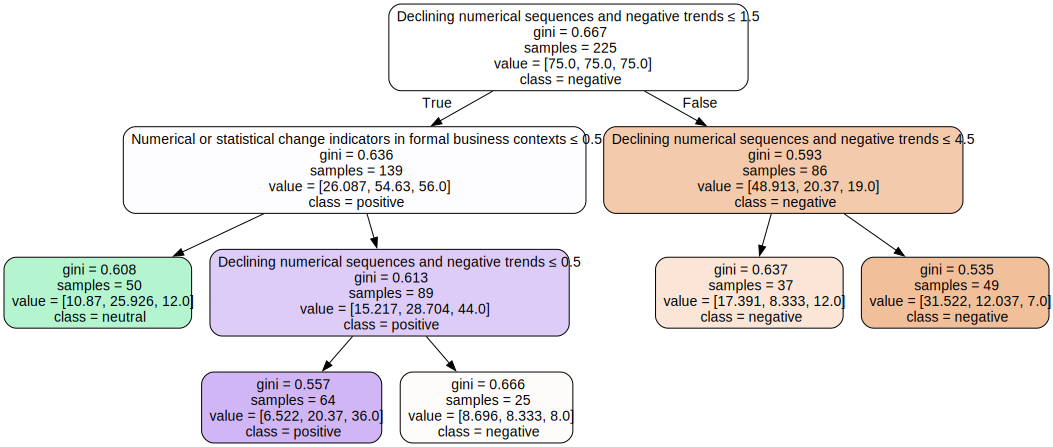

In [26]:
import graphviz

BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

dot_data = tree.export_graphviz(
    best_tree,
    out_file=None,
    feature_names=[feature.label for feature in best_features],
    class_names=["negative", "neutral", "positive"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph